# Music Genre Classification
## Modeling 
---

In [1]:
#Imports
import pandas as pd
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier,StackingClassifier
#pip install xgboost
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import ConfusionMatrixDisplay

import pickle
import os

#remove convergence warnings on hyperparameter tuning
import warnings
warnings.filterwarnings("ignore")

In [3]:
#import data
df = pd.read_csv('../data/genre_numerical_data.csv')

In [4]:
#check data
df.head()

,file_name,genre,global_tempo,zero_crossings,avg_zc_rate,std_zc_rate,avg_rms,std_rms,avg_amplitude_envelope,std_amplitude_envelope,...,avg_delta1_mfcc_24,std_delta1_mfcc_24,avg_delta2_mfcc_24,std_delta2_mfcc_24,avg_mfcc_25,std_mfcc_25,avg_delta1_mfcc_25,std_delta1_mfcc_25,avg_delta2_mfcc_25,std_delta2_mfcc_25
0,blues.00000.au,blues,123.0,55031.0,0.083074,0.027707,0.130360,0.053108,0.327602,0.140254,...,0.002245,2.584780,0.000505,1.465260,1.058656,37.768456,0.002283,2.544774,0.000335,1.443447
1,blues.00001.au,blues,108.0,37139.0,0.056064,0.038064,0.095905,0.048758,0.249066,0.140119,...,0.000356,3.524664,-0.004134,1.878435,-0.416541,53.829720,0.000848,3.463843,-0.004067,1.846598
2,blues.00002.au,blues,161.0,50563.0,0.076285,0.031682,0.175599,0.052479,0.444890,0.151819,...,-0.000813,3.028513,-0.000726,1.852521,0.139876,38.718422,-0.000571,2.981193,-0.000570,1.822811
3,blues.00003.au,blues,172.0,22077.0,0.033284,0.020516,0.141266,0.079632,0.306623,0.171395,...,-0.009183,3.269627,-0.000356,1.684101,-0.426795,53.465385,-0.008726,3.207656,-0.000323,1.652975
4,blues.00004.au,blues,136.0,67225.0,0.101487,0.044194,0.091617,0.048034,0.282141,0.167069,...,0.006547,3.204171,-0.001320,1.799860,-6.859077,46.151836,0.006658,3.149045,-0.001131,1.769600


In [4]:
#set feature matrix and response vector
y = df['genre']
l = LabelEncoder()
y = l.fit_transform(y)
y = pd.Series(y)
X = df.drop(columns = ['file_name', 'genre'])

In [5]:
#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify = y)

In [6]:
#scale data
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)
Z_train = pd.DataFrame(Z_train, columns = sc.get_feature_names_out())
Z_test = pd.DataFrame(Z_test, columns = sc.get_feature_names_out())

## Helper Functions

In [26]:
#provide model metrics
def model_evaluation(model, abbreviation):
    
    preds = model.predict(Z_test)
    train_acc = round(model.score(Z_train, y_train),2)
    test_acc = round(model.score(Z_test, y_test),2)
    
    print(f"Training Accuracy is: {train_acc}")
    print(f"Testing Accuracy is: {test_acc}")
    print()
    
    cm = ConfusionMatrixDisplay.from_estimator(model, Z_test, y_test,display_labels = ["blues","classical","country",
                                                                                      "disco","hiphop","jazz",
                                                                                      "metal","pop","reggae",
                                                                                      "rock"])
    plt.xticks(rotation = 90)
    
    data = {
        'Training Accuracy' : train_acc,
        'Testing Accuracy' : test_acc
    }
    return pd.DataFrame(data,index = [abbreviation])

In [119]:
#save models
def save_models(model_list, title_list):
    #make directory
    os.mkdir('../models')
    for model,title in zip(model_list, title_list):
        pickle.dump(model, open(f'../models/{title}.pkl', 'wb'))

### Logistic Regression

In [14]:
pipe_logr = Pipeline([
    ('kbest', SelectKBest()),
    ('logr', LogisticRegression(solver = 'saga', random_state=42, max_iter=1000))
])

logr_params = {
    'kbest__k' : [140,145,150,155],
    'logr__penalty' : [None, 'l1', 'l2'],
    'logr__C' : [.001, .01, .1, 1, 10]
}

gs_logr = GridSearchCV(pipe_logr, logr_params, n_jobs= -1)

gs_logr.fit(Z_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('kbest', SelectKBest()),
                                       ('logr',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'kbest__k': [140, 145, 150, 155],
                         'logr__C': [0.001, 0.01, 0.1, 1, 10],
                         'logr__penalty': [None, 'l1', 'l2']})

In [57]:
gs_logr.best_params_

{'kbest__k': 140, 'logr__C': 10, 'logr__penalty': 'l1'}

Training Accuracy is: 0.89
Testing Accuracy is: 0.76



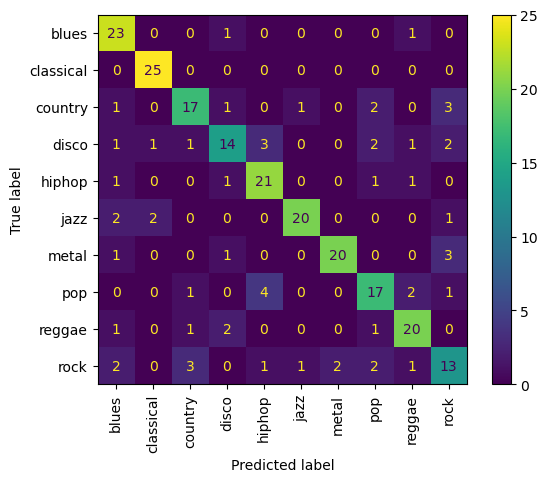

In [47]:
logr_results = model_evaluation(gs_logr, "Logistic Regression")

Model classifies Classical and Blues most accurately. Rock and Disco are the main problem areas. Disco and Hip-Hop share many similarities and so do Rock and Country.

### Ridge Classifier

In [44]:
pipe_ridge = Pipeline([
    ('kbest', SelectKBest()),
    ('ridge', RidgeClassifier(random_state=42))
])

ridge_params = {
    'kbest__k' : [130,135,140,145,150],
    'ridge__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'ridge__alpha' : [.001, .01, .1, 1, 10, 100]
}

gs_ridge = GridSearchCV(pipe_ridge, ridge_params, n_jobs= -1)

gs_ridge.fit(Z_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('kbest', SelectKBest()),
                                       ('ridge',
                                        RidgeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'kbest__k': [130, 135, 140, 145, 150],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                           'sparse_cg', 'sag', 'saga',
                                           'lbfgs']})

In [45]:
gs_ridge.best_params_

{'kbest__k': 135, 'ridge__alpha': 0.001, 'ridge__solver': 'sparse_cg'}

Training Accuracy is: 0.89
Testing Accuracy is: 0.77



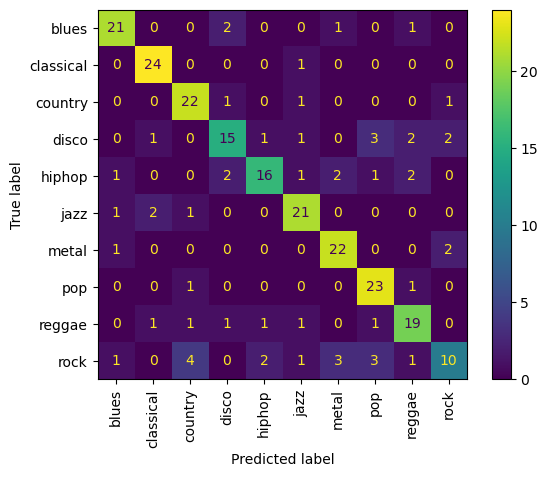

In [46]:
ridge_results = model_evaluation(gs_ridge, "Ridge Classifier")

Like the previous model, Ridge classifies Classical and Blues well. Unlike the Logistic model, most Country tracks were accurately classified. Rock and Disco are the main problem areas once again.Additionally, many Hip-Hop tracks were misclassified as Disco and suprisingly as Meta.

### XGBoost

In [83]:
pipe_xgb = Pipeline([
    ('kbest', SelectKBest()),
    ('xgb', XGBClassifier(random_state=42, verbosity = 0, tree_method = 'hist'))
])

xgb_params = {
    'kbest__k' : [115,120,125,130,135,140],
    'xgb__eta' : [.3, .4, .5],
    'xgb__gamma' : [0, 10, 100],
    'xgb__max_depth' : [4,5,6],
    'xgb__min_child_weight' : [1,2,3],
}

gs_xgb = GridSearchCV(pipe_xgb, xgb_params, n_jobs= -1)

gs_xgb.fit(Z_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('kbest', SelectKBest()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_p

In [84]:
gs_xgb.best_params_

{'kbest__k': 140,
 'xgb__eta': 0.3,
 'xgb__gamma': 0,
 'xgb__max_depth': 4,
 'xgb__min_child_weight': 1}

Training Accuracy is: 1.0
Testing Accuracy is: 0.74



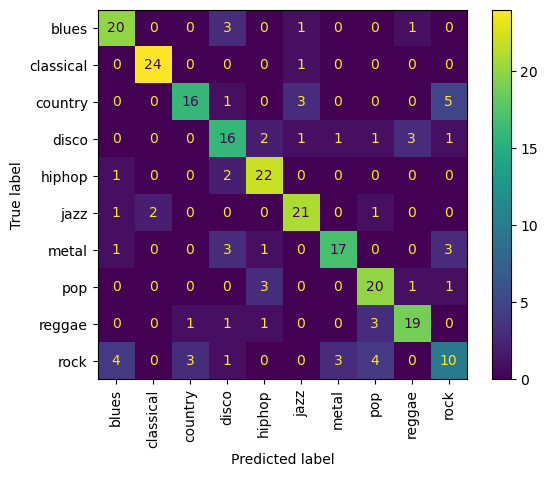

In [85]:
xgb_results = model_evaluation(gs_xgb, "XGBoost")

As usual, Classical music is the most accurately categorized and Rock is the least accurately categorized. This model has problems classifying Disco and Country like the Logistic model. Lastly, of all three models studied thus far, this performs the worse classifying Metal.

In [122]:
# Get feature importances for XGB Model
importance = gs_xgb.best_estimator_.named_steps['xgb'].feature_importances_

# Create a list of column names
column_names = Z_train.columns

# Sort feature importances in descending order
indices = np.argsort(importance)[::-1]

# Print top 10 feature ranking
print("XGB's Top 10 Feature Ranking:")
for f in range(10):
    print(f"{f+1}. Feature '{column_names[indices[f]]}' ({importance[indices[f]]})")


XGB's Top 10 Feature Ranking:
1. Feature 'avg_delta1_mfcc_25' (0.05623739957809448)
2. Feature 'avg_mfcc_7' (0.046143196523189545)
3. Feature 'avg_delta1_mfcc_17' (0.04266294091939926)
4. Feature 'avg_mfcc_12' (0.039036620408296585)
5. Feature 'avg_delta1_mfcc_23' (0.03349390625953674)
6. Feature 'avg_mfcc_9' (0.02858019433915615)
7. Feature 'avg_mfcc_16' (0.027602940797805786)
8. Feature 'avg_mfcc_15' (0.025718534365296364)
9. Feature 'avg_delta1_mfcc_19' (0.023179687559604645)
10. Feature 'std_mfcc_23' (0.022071940824389458)


MFCCs are known to contain important spectral information about a piece of audio. Interestingly, all of the top 10 most important features are related to it.

### Linear Discriminant Analysis

In [74]:
pipe_da = Pipeline([
    ('kbest', SelectKBest()),
    ('da', LinearDiscriminantAnalysis())
])

da_params = {
    'kbest__k' : [115,120,125,130,135,140,145],
    'da__solver' : ['svd', 'lsqr', 'eigen'],
    'da__shrinkage' : ['auto', None]
}

gs_da = GridSearchCV(pipe_da, da_params, n_jobs= -1)

gs_da.fit(Z_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('kbest', SelectKBest()),
                                       ('da', LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid={'da__shrinkage': ['auto', None],
                         'da__solver': ['svd', 'lsqr', 'eigen'],
                         'kbest__k': [115, 120, 125, 130, 135, 140, 145]})

In [75]:
gs_da.best_params_

{'da__shrinkage': None, 'da__solver': 'svd', 'kbest__k': 140}

Training Accuracy is: 0.93
Testing Accuracy is: 0.82



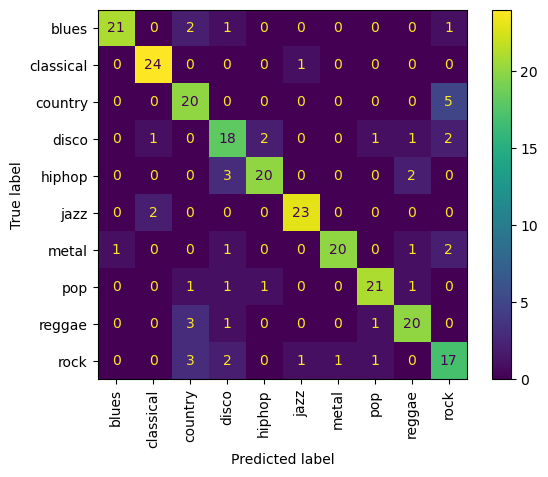

In [76]:
da_results = model_evaluation(gs_da, "Linear Discriminant Analysis")

Overall, this model performed the best on the testing data. The difference is most evident when viewing the rock category metrics. The boundaries between Country/Rock and Hip-Hop/Disco continue to be the most obvious problem areas. 

### Linear Support Vectors

In [69]:
pipe_svc = Pipeline([
    ('kbest', SelectKBest()),
    ('svc',LinearSVC(random_state=42))
])

svc_params = {
    'kbest__k' : [120,125,130,135,140,145,150,155],
    'svc__C' : [.001,.01,.1, 1, 10, 100]
}

gs_svc = GridSearchCV(pipe_svc, svc_params, n_jobs= -1)

gs_svc.fit(Z_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('kbest', SelectKBest()),
                                       ('svc', LinearSVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'kbest__k': [120, 125, 130, 135, 140, 145, 150, 155],
                         'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [70]:
gs_svc.best_params_

{'kbest__k': 120, 'svc__C': 1}

Training Accuracy is: 0.87
Testing Accuracy is: 0.77



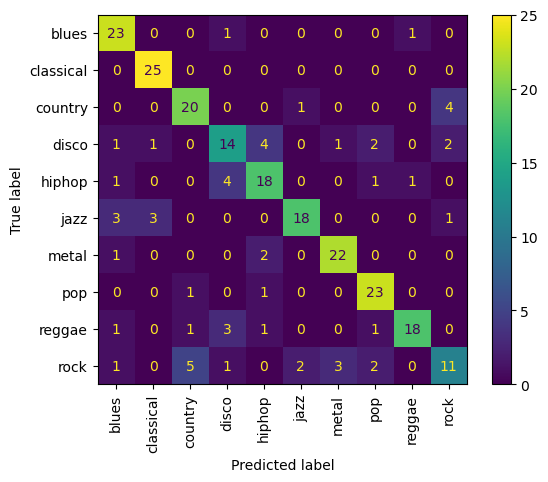

In [78]:
svc_results = model_evaluation(gs_svc, "Linear Support Vectors")

This model classifies all of the actual Classical pieces correctly. However, it suffers with some of the same issues as the Ridge Model.

### Voting Classifier

In [95]:
vote = VotingClassifier([
    ('lsvc',LinearSVC(random_state=42)),
    ('da',LinearDiscriminantAnalysis()),
    ('r',RidgeClassifier(random_state=42)),
    ('logr',LogisticRegression(random_state=42)),
])

vote.fit(Z_train, y_train)

VotingClassifier(estimators=[('lsvc', LinearSVC(random_state=42)),
                             ('da', LinearDiscriminantAnalysis()),
                             ('r', RidgeClassifier(random_state=42)),
                             ('logr', LogisticRegression(random_state=42))])

Training Accuracy is: 0.94
Testing Accuracy is: 0.79



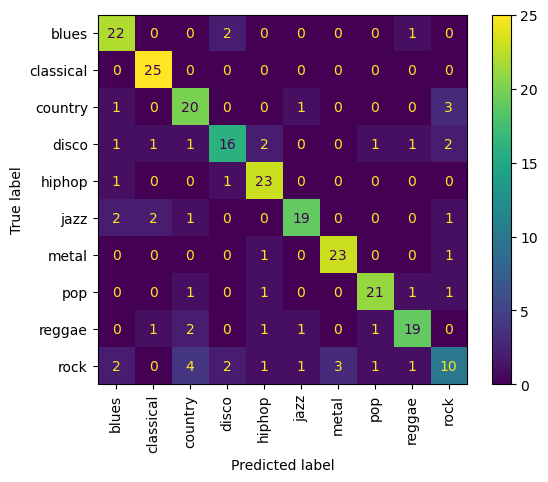

In [96]:
vote_results = model_evaluation(vote, "Voting Classifier")

This model's performance is highly similar to the Linear Support Vector Model.

### Stacking Classifier

In [105]:
level1_estimators = [
    ('lsvc',LinearSVC(random_state=42)),
    ('da',LinearDiscriminantAnalysis()),
    ('r',RidgeClassifier(random_state=42)),
    ('logr',LogisticRegression(random_state=42))
]
stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression(max_iter=10000),n_jobs=-1)
stacked_model.fit(Z_train,y_train)

StackingClassifier(estimators=[('lsvc', LinearSVC(random_state=42)),
                               ('da', LinearDiscriminantAnalysis()),
                               ('r', RidgeClassifier(random_state=42)),
                               ('logr', LogisticRegression(random_state=42))],
                   final_estimator=LogisticRegression(max_iter=10000),
                   n_jobs=-1)

Training Accuracy is: 0.95
Testing Accuracy is: 0.82



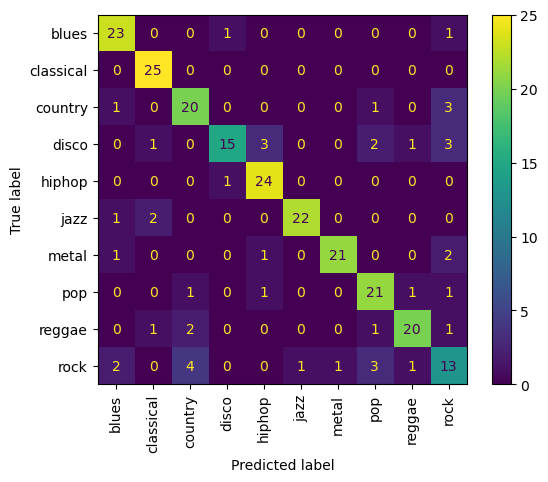

In [106]:
stacked_results = model_evaluation(stacked_model, "Stacking Classifier")

This model is tied with the Linear Discriminant Analysis model for best performance on the testing data. It perfroms worse with classifying Rock but outperforms the LDA in classfying Hip-Hop and Blues.

In [121]:
#save models in model folder
save_models([gs_logr.best_estimator_,gs_ridge.best_estimator_,gs_xgb.best_estimator_,gs_da.best_estimator_,
             gs_svc.best_estimator_,vote,stacked_model],
            ['logr', 'ridge', 'xgb', 'da', 'svc', 'vote', 'stacked'])

### Interpretation

In [111]:
#concatenate all metric dataframes
metrics = pd.concat([logr_results, ridge_results, da_results, svc_results, vote_results, xgb_results, stacked_results])
metrics.sort_values(['Testing Accuracy', 'Training Accuracy'], ascending = [False,True])

,Training Accuracy,Testing Accuracy
Linear Discriminant Analysis,0.93,0.82
Stacking Classifier,0.95,0.82
Voting Classifier,0.94,0.79
Linear Support Vectors,0.87,0.77
Ridge Classifier,0.89,0.77
Logistic Regression,0.89,0.76
XGBoost,1.00,0.74


Each of these models performed better than the people in the GTZAN study relevant to accuracy. However, all models are overfit. More work needs to be done to reduce the variance. As mentioned, the LDA and Stacking Classifiers are the best performers and most likely candidates for use in actual production. All models struggled in classfying genres most likely due to the number of classes and the similarities shared among the classes. Nevertheless, the performance of these models suggests that there can be effective use of machine learning in classifying music. Streaming companies can greatly benefit from the use of machine learning to better arrange its music to provide the best experience for its customers. 